# NCHU 4105056004 資工二 許哲維

# MNIST 手寫數字辨識 & CNN

### NO.1 匯入 Keras 和模組

先進行匯入

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # 查看硬體資源
np.random.seed(10)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17824797964294172318
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10968950375
locality {
  bus_id: 1
}
incarnation: 5250444501775371106
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0d:00.0, compute capability: 6.1"
]


忽略掉不必要的warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

### NO.2 下載 mnist 資料

下載 Mnist 資料 
我們將建立以下 Keras 程式, 下載並讀取 mnist 資料.

In [3]:
from keras.datasets import mnist

### NO.3 讀取和查看mnis資料

In [4]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("\t[Info] train data={:7,}".format(len(X_train_image)))  
print("\t[Info] test  data={:7,}".format(len(X_test_image))) 

	[Info] train data= 60,000
	[Info] test  data= 10,000


由上可以知道 training data 共有 60,000 筆; testing data 共有 10,000 筆。

## 查看訓練資料
接著我們來看載入資料的長相與格式

### NO.1 訓練資料是由 images 與 labels 所組成

In [5]:
print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)


訓練資料是由 images 與 labels 所組成共有 60,000 筆, 每一筆代表某個數字的影像為 28x28 pixels.

### NO.2 定應 plot_image 函數顯示數字影像

In [6]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()
def plot_image_color(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image) # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

### NO.3 執行 plot_image 函數查看第 0 筆數字影像與 label 資料 

以下程式呼叫 plot_image 函數, 傳入 X_train_image[0], 也就是順練資料集的第 0 筆資料, 顯示結果可以看到這是一個數字 5 的圖形: 

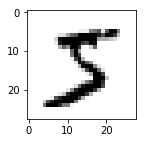

In [7]:
plot_image(X_train_image[0])

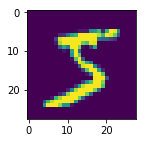

In [8]:
plot_image_color(X_train_image[0])

我很好奇他原本的顏色

In [9]:
y_train_label[0]

5

## 查看多筆訓練資料 images 與 labels

接下來我們將建立 plot_images_labels_predict 函數, 可以顯示多筆資料的影像與 label. 

### NO.1 建立 plot_images_labels_predict() 函數

因為後續我們希望能很方便查看數字圖形, 真實的數字與預測結果, 所以我們建立了以下函數:

In [10]:
#預設一次顯示10張
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    #最多一次顯示25張
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        #如果有輸入prediction的話 len()就會大於0=>顯示L和P
        if len(prediction) > 0:  
            title = "label={},predict={}".format(str(labels[idx]), str(prediction[idx]))  
        #如果沒有輸入prediction的話=>只需顯示L
        else:  
            title = "label={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

### NO.2 查看訓練資料的前 10 筆資料

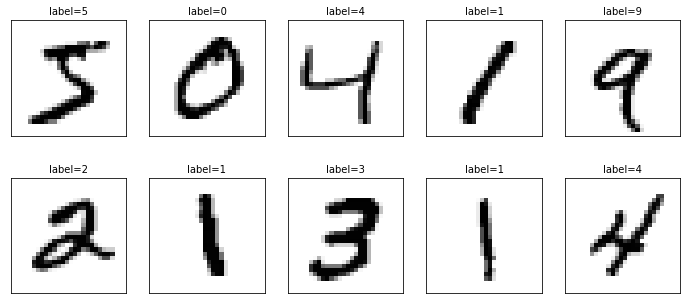

In [11]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0, 10)

## 多層感知器模型資料前處理

接下來我們建立 多層感知器模型 (MLP), 我們必須先將 images 與 labels 的內容進行前處理, 才能餵進去 Keras 預期的資料結構。

### NO.1 features (數字影像的特徵值) 資料前處理

首先將 image 以 reshape 轉換為二維 ndarray 
因正常照片為 RGB 三維度，而這邊只有灰階
而 Conv2D data 需要多一個維度，在此增加
並進行 normalization (Feature scaling): 

In [12]:
x_Train = X_train_image.reshape(60000, 28, 28).astype('float32')
x_Test = X_test_image.reshape(10000, 28, 28).astype('float32')

x_Train = x_Train[:,:,:,np.newaxis] #為了能fit進Conv2d需要多加一個維度
x_Test = x_Test[:,:,:,np.newaxis]

print("\t[Info] xTrain: %s" % (str(x_Train.shape)))
print("\t[Info] xTest: %s" % (str(x_Test.shape)))
  
# Normalization
x_Train_norm = x_Train/255
x_Test_norm = x_Test/255

	[Info] xTrain: (60000, 28, 28, 1)
	[Info] xTest: (10000, 28, 28, 1)


### NO.2 labels (影像數字真實的值) 資料前處理

label 標籤欄位原本是 0-9 數字, 而為了配合 Keras 的資料格式, 我們必須進行 One-hot-encoding 將之轉換為 10 個 0 或 1 的組合, 例如數字 7 經過 One-hot encoding 轉換後是 0000001000, 正好對應到輸出層的 10 個神經元. 下面簡單測試過程:

In [13]:
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding

print(y_train_label[0]) # 檢視 training labels 第一個 label 的值
print(y_TrainOneHot[0]) # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

5
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


## 建立模型
首先我們使用了兩層 Convolution 卷積層並以 Relu 為 activation function
以及各對應的 Pooling.
再來接上多層感知器 Multilayer Perceptron 模型.
輸出層共有 10 個神經元，以 sonftmax 為 activation function.

Conv2D => 捲積層:
用來把圖片的特徵給抓出來，每張圖片會經過多次不同的捲積圖片，產生出新的圖片，讓機器更好學習它的特徵
![](https://cdn-images-1.medium.com/max/1000/1*CO0yrGvAE7jw6JfGqCMRPg.png)
![](https://cdn-images-1.medium.com/max/1000/1*AJeWQ88UnmfkJ4_sFOT-YA.png)

MaxPooling2D =>池化層:
把圖片縮小，在特定大小內選出最大值，將這些最大值組成新的圖片
![](https://cdn-images-1.medium.com/max/1000/1*-Yo6iC0S3QLWqgAPnV9knQ.png)
![](https://cdn-images-1.medium.com/max/1000/1*CGwpxQT5kJho3CbDZy2Qkw.png)

Flatten => 全連接層:
圖片都是二為矩陣(這裡採用灰階所以第三為只有1，當二維)，將二為轉為一為矩陣
![](https://cdn-images-1.medium.com/max/1000/1*nzZGTF1yypBAQVRVFgvXAA.png)

在層跟層之間通常會Drop掉一定比例的神經元來避免Overfit的狀況，要Drop掉多少比例沒有一個特定的值，通常是25%~50%之間

In [14]:
from keras.models import Sequential  
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
  
model = Sequential()  # Build Linear Model 


#Conv layer 1 output shape (64, 28, 28)
model.add(Conv2D(
    filters=64,
    kernel_size=(5, 5),  # feature detector 的大小 5x5
    padding='same',      # Padding method
    input_shape=(28,28,1),
    activation='relu'
))

# MaxPooling layer1 size (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))


# Drop 掉一些神經元 避免 overfitting
model.add(Dropout(0.25))

#全連接層
model.add(Flatten())


model.add(Dense(units=128, kernel_initializer='normal', activation='relu')) # Add Input/hidden layer
model.add(Dropout(0.3))
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax')) # Add Hidden/output layer  
print("\t[Info] Model summary:")  
model.summary()  
print("")


	[Info] Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)              

訓練模型

在訓練模型之前, 我們必須先使用 compile 方法, 對訓練模型進行設定, 代碼如下:

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

參數說明如下:
* **loss** : 設定 loss function, 在深度學習通常使用 cross_entropy (Cross entropy) 交叉摘順練效果較好.
* **optimizer** : 設定訓練時的優化方法, 在深度學習使用 adam 可以讓訓練更快收斂, 並提高準確率.
* **metrics** : 設定評估模型的方式是 accuracy (準確率)

開始訓練

In [ ]:
train_history = model.fit(x=x_Train_norm, 
                          y=y_TrainOneHot, 
                          validation_split=0.2, 
                          epochs=20, 
                          batch_size=200, 
                          verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 4s - loss: 0.3512 - acc: 0.8950 - val_loss: 0.0977 - val_acc: 0.9717
Epoch 2/20
 - 3s - loss: 0.1020 - acc: 0.9698 - val_loss: 0.0614 - val_acc: 0.9827
Epoch 3/20
 - 3s - loss: 0.0706 - acc: 0.9786 - val_loss: 0.0518 - val_acc: 0.9843
Epoch 4/20
 - 3s - loss: 0.0550 - acc: 0.9831 - val_loss: 0.0442 - val_acc: 0.9865
Epoch 5/20
 - 3s - loss: 0.0462 - acc: 0.9856 - val_loss: 0.0431 - val_acc: 0.9883
Epoch 6/20
 - 3s - loss: 0.0391 - acc: 0.9873 - val_loss: 0.0416 - val_acc: 0.9881
Epoch 7/20
 - 3s - loss: 0.0338 - acc: 0.9890 - val_loss: 0.0419 - val_acc: 0.9875
Epoch 8/20
 - 3s - loss: 0.0292 - acc: 0.9909 - val_loss: 0.0375 - val_acc: 0.9888
Epoch 9/20
 - 3s - loss: 0.0246 - acc: 0.9922 - val_loss: 0.0367 - val_acc: 0.9896
Epoch 10/20
 - 3s - loss: 0.0217 - acc: 0.9928 - val_loss: 0.0387 - val_acc: 0.9890
Epoch 11/20
 - 3s - loss: 0.0202 - acc: 0.9933 - val_loss: 0.0377 - val_acc: 0.9896
Epoch 12/20
 - 3s - loss: 0.0192 - 

上面訓練過程會儲存於 train_history 變數中, 參數說明如下: 

* **x = x_Train_norm** : features 數字的影像特徵值 (60,000 x 784 的陣列)
* **y = y_Train_OneHot** : label 數字的 One-hot encoding 陣列 (60,000 x 10 的陣列)
* **validation_split = 0.2** : 設定訓練資料與 cross validation 的資料比率. 也就是說會有 0.8 * 60,000 = 48,000 作為訓練資料; 0.2 * 60,000 = 12,000 作為驗證資料.
* **epochs** = 10 : 執行 10 次的訓練週期.
* **batch_size = 200** : 每一批次的訓練筆數為 200
* **verbose = 2** : 顯示訓練過程. 共執行 10 次 epoch (訓練週期), 每批 200 筆, 也就是每次會有 240 round (48,000 / 200 = 240). 每一次的 epoch 會計算 accuracy 並記錄在 train_history 中.

建立 show_train_history 顯示訓練過程

之前訓練步驟會將每一個訓練週期的 accuracy 與 loss 記錄在 train_history 變數. 我們可以使用下面程式碼讀取 train_history 以圖表顯示訓練過程:

In [ ]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

In [ ]:
show_train_history(train_history, 'acc', 'val_acc')

In [ ]:
show_train_history(train_history, 'loss', 'val_loss')

總共執行 20 個 Epoch 訓練週期, 可以發現:    
* 不論訓練與驗證, 誤差越來越低.
* 在 Epoch 訓練後期, "loss 訓練的誤差" 比 "val_loss 驗證的誤差" 小.

評估模型準確率

In [ ]:
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

進行預測
前面我們建立模型並於訓練後達成可以接受的 97% 準確率, 接著我們將使用此模型進行預測。

In [ ]:
print("\t[Info] Making prediction to x_Test_norm")  
prediction = model.predict_classes(x_Test_norm)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
print("%s\n" % (prediction[240:250]))  
  
plot_images_labels_predict(X_test_image, y_test_label, prediction, idx=240)